In [130]:
import duckdb
import pandas as pd
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from utils.quack import Quack
from sim_utils.modeling import update_config

In [131]:
rusher_stat_cols =[
 'carries_roll',
 'rushing_yards_roll',
 #'rushing_tds_roll',
 #'rushing_first_downs_roll',
 #'receiving_yards_roll',
 #'receiving_tds_roll',
 #'fantasy_points_ppr_roll',
 'yards_per_carry_roll']

team_stat_cols = [
 #'completions_team_roll',
 #'attempts_team_roll',
 'carries_team_roll',
 #'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'pass_pct_team_roll',
 'yards_per_carry_team_roll',
]
opp_stat_cols = [
#'completions_opp_roll',
 #'attempts_opp_roll',
 'carries_opp_roll',
 #'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll',
 'yards_per_carry_opp_roll',
]

game_context_cols = [
	"yardline_100",
	"ydstogo",
	"down",
	"goal_to_go",
	#"posteam_score",
	#"defteam_score",
	#"score_differential",
	#'quarter_seconds_remaining',
	#'half_seconds_remaining',
	#'game_seconds_remaining',
	#"wind",
	#"temp",
	#'spread_line',
	#'total_line',
]

x_cols = game_context_cols +rusher_stat_cols + ['is_first_down', 'is_second_down', 'is_third_down','is_fourth_down', 'touchdown', 'short_to_first'] #+ ['run_gap_encoded'] + rusher_stat_cols + team_stat_cols + opp_stat_cols 

In [132]:
def select_columns(cols:list, alias:str=None, coalesce=False):

	if alias:
		temp = (f'{alias}.' + x for x in cols)
	else:
		temp = cols
	if coalesce:
		temp = (f'coalesce({x}, 0) as {y}' for x,y in zip(temp, cols))
	return ', '.join(temp)


select_columns(rusher_stat_cols, alias='abc')

'abc.carries_roll, abc.rushing_yards_roll, abc.yards_per_carry_roll'

In [133]:
rushes = Quack.query(f"""
select pbp.desc,pbp.game_id, pbp.yards_gained,pbp.yards_gained + 30 as yards_shifted,
	case when pbp.down = 1 then 1 else 0 end as is_first_down,
	case when pbp.down = 2 then 1 else 0 end as is_second_down,
	case when pbp.down = 3 then 1 else 0 end as is_third_down,
	case when pbp.down = 4 then 1 else 0 end as is_fourth_down,
	pbp.first_down, pbp.touchdown,
	case when pbp.ydstogo < 3 then 1 else 0 end as short_to_first,
	{select_columns(game_context_cols, alias='pbp', coalesce=False)},
	{select_columns(team_stat_cols, alias='t', coalesce=True)},
	{select_columns(opp_stat_cols, alias='o', coalesce=True)},
	{select_columns(rusher_stat_cols, alias='r', coalesce=True)}
	from pbp join team_feats as t 
	on pbp.posteam = t.team
	and pbp.game_id = t.game_id
	join opp_feats as o
	on pbp.defteam = o.opponent_team
	and pbp.game_id = o.game_id
	join player_weekly_agg as r
	on r.game_id = pbp.game_id
	and pbp.rusher_player_id = r.gsis_id
	and r.team = pbp.posteam
	and pbp.play_type = 'run'
	and pbp.yards_gained is not null
	and pbp.down is not null
	and pbp.penalty = 0
	and pbp.fumble = 0
""")

rushes[rusher_stat_cols] = rushes[rusher_stat_cols].fillna(0)

X = rushes[x_cols]
y = rushes['yards_shifted']
X_td = rushes.loc[rushes.touchdown==1][x_cols].copy().reset_index(drop=True)
y_td = rushes.loc[rushes.touchdown==1]['yards_shifted'].copy().reset_index(drop=True)

In [134]:
import torch
import torch.nn as nn

class ResBlock(nn.Module):
	def __init__(self, n_hidden):
		super().__init__()
		self.layer = nn.Sequential(
			nn.LayerNorm(n_hidden),
			nn.Linear(n_hidden, n_hidden),
			nn.ReLU()
		)
	
	def forward(self, x):
		return x + self.layer(x)


class masked_model(nn.Module):
	def __init__(self, n_in=11, n_out=130, n_hidden=512):
		super(masked_model, self).__init__()
		self.n_out=n_out
		self.main_layers = nn.Sequential(
		nn.Linear(n_in, n_hidden),nn.ReLU(),
		ResBlock(n_hidden),
		ResBlock(n_hidden),
		ResBlock(n_hidden),
		ResBlock(n_hidden),
		ResBlock(n_hidden),
		ResBlock(n_hidden),
		ResBlock(n_hidden),
		)
		self.output_layer  = nn.Linear(n_hidden, n_out)
		self.td_head = nn.Sequential(nn.Linear(n_in, n_hidden),nn.ReLU(),
		ResBlock(n_hidden), nn.Linear(n_hidden,1))
	def forward(self, x):

		
		# Extract the feature to pass to the final layer (e.g., the first feature)
		yardline = x[:, 0].unsqueeze(1)  # Assuming you want the first feature, shape [batch_size, 1]
		td_bin = (yardline + 30).long().squeeze(1)
		td_logits = self.td_head(x)
		x = self.main_layers(x)
		logits = self.output_layer(x)
		batch_indices = torch.arange(logits.size(0), device=logits.device)
		logits[batch_indices, td_bin] = logits[batch_indices, td_bin] + td_logits.squeeze(1)
		
		yard_values = torch.arange(-30, self.n_out - 30, device=x.device).float().unsqueeze(0)
		mask = (yard_values <= yardline).float()
		logits = logits + (mask - 1) * 1e9

		return logits

In [135]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)

def get_sample(num_samples):
	idx = np.random.randint(0,len(X_tensor), num_samples)
	return X_tensor[idx]

model = masked_model(
	n_in=len(x_cols),
	n_out=130,
	n_hidden=64,
)

c = get_sample(5)
pred = model(c)

In [136]:
c[:,1] > c[:,2]

tensor([True, True, True, True, True])

In [138]:
torch.arange(40)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39])

In [139]:

# Example tensors
probs = torch.randn(9, 130)       # [batch, features]
probs = torch.softmax(probs, dim=1)
ydstogo = torch.randint(0, 130, (9,))  # [batch]
print(ydstogo)

# Create a mask
mask = torch.arange(probs.size(1)).unsqueeze(0) >= ydstogo.unsqueeze(1)  # [9, 130]

# Apply mask
masked_output = probs * mask

print(masked_output.sum(1))


tensor([ 91,  59,  26, 112, 124, 101, 108, 112, 123])
tensor([0.2530, 0.5468, 0.8638, 0.1233, 0.0237, 0.1712, 0.1711, 0.1013, 0.0525])


In [140]:
class FocalLoss(nn.Module):
	def __init__(self, gamma=2.0):
		super().__init__()
		self.gamma = gamma
	
	def forward(self, logits, targets):
		ce_loss = F.cross_entropy(logits, targets, reduction='none')
		pt = torch.exp(-ce_loss)
		focal_loss = ((1 - pt) ** self.gamma) * ce_loss
		return focal_loss.mean()

In [141]:
class FocalLossSoft(nn.Module):
	def __init__(self, gamma=2.0):
		super().__init__()
		self.gamma = gamma

	def forward(self, logits, targets):  # targets: [B, num_classes]
		log_probs = F.log_softmax(logits, dim=1)
		probs = log_probs.exp()
		loss = -((1 - probs) ** self.gamma) * targets * log_probs
		return loss.sum(dim=1).mean()

In [142]:
def adjacent_label_smoothing(labels,yardline, num_classes=130, smoothing=0.1):
	batch_size = labels.size(0)
	smoothed = torch.zeros(batch_size, num_classes, device=labels.device)
	
	for i, label in enumerate(labels):
		label = label.item()
		smoothed[i, label] = 1.0 - smoothing
		
		if label > 0:
			smoothed[i, label - 1] = smoothing / 2
		else:
			smoothed[i, label] += smoothing / 2
		
		if label < num_classes - 1:
			smoothed[i, label + 1] = smoothing / 2
		else:
			smoothed[i, label] += smoothing / 2
	
	mask = torch.arange(smoothed.size(1)).expand(len(rushes['yardline_100']), -1) > torch.tensor(rushes['yardline_100'] + 30).unsqueeze(1)
	smoothed[mask] = 0

	return smoothed

In [ ]:
def train_model(X, y, n_in, n_out,n_hidden=50, epochs=20, batch_size=128, model=None):

	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	y = torch.tensor(y,dtype=torch.long).to(device)
	# Define the model, loss function, and optimizer
	
	X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
	smoothed_y = adjacent_label_smoothing(y,X_tensor[:,0], num_classes=130, smoothing = 0.1)
	if not model:
		model = masked_model(
		n_in=n_in,
		n_out=n_out,
		n_hidden=n_hidden,
		).to(device)
	criterion = FocalLossSoft(gamma=2)
	td_criterion = nn.CrossEntropyLoss()
	fd_criterion = nn.CrossEntropyLoss()
	criterion_mse = nn.MSELoss()
	optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.007)

	num_samples = X_tensor.size(0)
	indices = torch.randperm(num_samples, device=device)

	# Calculate train-test split sizes
	split = num_samples // 5  # 20% test data
	test_indices = indices[:split]
	train_indices = indices[split:]

	# Create train-test splits using the shuffled indices

	Xtr = X_tensor[train_indices].to(device)
	Xtst = X_tensor[test_indices].to(device)
	train_y = y[train_indices].to(device)
	train_y_smooth = smoothed_y[train_indices].to(device)
	test_y =  y[test_indices].to(device)
	test_y_smooth = smoothed_y[test_indices].to(device)
	train_is_td = (y[train_indices] >= (30 +  Xtr[:,0])).float()
	train_is_fd = (y[train_indices] >= (30 + Xtr[:,1])).float()
	print(train_is_fd.mean())
	print(train_is_td.mean())
	# Training loop

	for epoch in range(epochs):
		model.train()
		permutation = torch.randperm(Xtr.size(0))
		epoch_mean_loss = 0
		epoch_class_loss = 0

		for i in range(0, Xtr.size(0), batch_size):
			batch_idx = permutation[i:i + batch_size]
			batch_x, batch_y, batch_y_smooth, batch_td, batch_fd = Xtr[batch_idx], train_y[batch_idx], train_y_smooth[batch_idx],train_is_fd[batch_idx], train_is_td[batch_idx]

			optimizer.zero_grad()
			outputs = model(batch_x)  # Shape: [batch_size, n_out]
			probs = torch.softmax(outputs, dim=1)


			fd_mask = torch.arange(probs.size(1), device=device).unsqueeze(0) >= batch_x[:,0].unsqueeze(1)  # [9, 130]
			fd_output = (probs * fd_mask).sum(1)
			td_mask = torch.arange(probs.size(1),device=device).unsqueeze(0) >= batch_x[:,0].unsqueeze(1)  # [9, 130]
			td_output = (probs * fd_mask).sum(1)
			td_loss = td_criterion(fd_output, batch_fd) * 0.5
			fd_loss = fd_criterion(fd_output, batch_fd) * 0.5

			probs_mean = (torch.arange(0,n_out, dtype=torch.float32).to(device) * probs).sum(1)
			classifier_loss = criterion(outputs, batch_y_smooth)
			mean_loss =  criterion_mse(probs_mean, batch_y.float()) 
			loss = classifier_loss + mean_loss + td_loss + fd_loss
			loss.backward()
			optimizer.step()

			epoch_mean_loss += mean_loss.item()
			epoch_class_loss += classifier_loss.item()
		n_batches = len(range(0, Xtr.size(0), batch_size))
		print(f"Epoch {epoch+1}/{epochs}, Classifier Loss: {epoch_class_loss/n_batches:.4f}, MSE Loss: {epoch_mean_loss/n_batches:.4f}")


		model.eval()
		with torch.no_grad():
			test_preds = model(Xtst)
			test_loss = criterion(test_preds, test_y_smooth).item() 
			accuracy = (test_preds.argmax(dim=1) == test_y).float().mean().item()
		print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")

		test_preds = F.softmax(test_preds,dim=1)[0].to('cpu')
	plt.hist(test_preds, alpha=0.5, color='r')
	plt.hist(test_y.to('cpu'), alpha=0.5, color='b')
	return model

tensor(0.2478, device='cuda:0')
tensor(0.0340, device='cuda:0')
Epoch 1/20, Classifier Loss: 20.6763, MSE Loss: 42.8802
Test Loss: 12.4843, Test Accuracy: 0.1223
Epoch 2/20, Classifier Loss: 14.1626, MSE Loss: 40.6497
Test Loss: 13.9646, Test Accuracy: 0.0685
Epoch 3/20, Classifier Loss: 8.1676, MSE Loss: 39.0475
Test Loss: 7.0706, Test Accuracy: 0.1209
Epoch 4/20, Classifier Loss: 7.1808, MSE Loss: 37.9042
Test Loss: 4.6302, Test Accuracy: 0.1383
Epoch 5/20, Classifier Loss: 4.8776, MSE Loss: 36.5256
Test Loss: 4.4390, Test Accuracy: 0.1083
Epoch 6/20, Classifier Loss: 3.6939, MSE Loss: 35.1037
Test Loss: 2.9973, Test Accuracy: 0.1357
Epoch 7/20, Classifier Loss: 2.8978, MSE Loss: 33.9684
Test Loss: 2.7443, Test Accuracy: 0.1179
Epoch 8/20, Classifier Loss: 2.8900, MSE Loss: 34.5384
Test Loss: 3.1395, Test Accuracy: 0.0989
Epoch 9/20, Classifier Loss: 2.7636, MSE Loss: 33.8724
Test Loss: 2.5742, Test Accuracy: 0.1577
Epoch 10/20, Classifier Loss: 2.6028, MSE Loss: 33.8162
Test Loss: 2

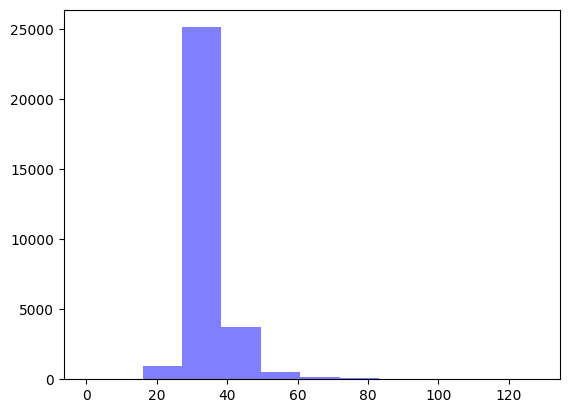

In [144]:
rush_yards_model = train_model(X,y, n_in=len(x_cols), n_out=130, n_hidden = 512, epochs=20)

#Test Loss: 2.3133, Test Accuracy: 0.1709 
#Test Loss: 2.8949, Test Accuracy: 0.1649 add label smoothing, no focal loss
#Test Loss: 2.4887, Test Accuracy: 0.1709 smoothing + focal + remove 1st down leakage
#Test Loss: 2.4681, Test Accuracy: 0.1682 maskedmodel2
#Test Loss: 2.4735, Test Accuracy: 0.1648 hierarchical thing
#Test Loss: 2.4042, Test Accuracy: 0.1596 

In [145]:

rush_yards_model = rush_yards_model.to('cpu')
model_path = "models/run_yards_gained.pt"
torch.save(rush_yards_model.state_dict(), model_path)


feature_config = {
	'rush_yard_cols':x_cols
}
feature_config

update_config(feature_config)

Actual mean: 4.89, Model mean: 4.24
number of datapoints: 505


(-20.0, 25.0)

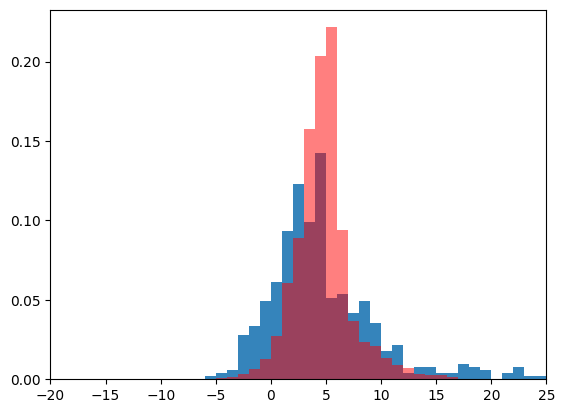

In [150]:
def sample_model_yardline(yard, down):
	sample = rushes.loc[(rushes.ydstogo == yard) & (rushes.down == down) & (rushes.yardline_100 > 15)]
	inp =  sample[x_cols]
	y = sample['yards_gained']

	inp =  torch.tensor(inp.values, dtype=torch.float32)
	out = rush_yards_model(inp).mean(0).detach().numpy()
	exp_logits = np.exp(out - np.max(out))
	probs = exp_logits / exp_logits.sum()
	plt.hist(y, range(-30,100), density=True, alpha=0.9)

	actual_mean = y.mean()
	model_mean = (np.arange(len(probs)) - 30) @ probs  # adjust if 0th class = -30
	print(f"Actual mean: {actual_mean:.2f}, Model mean: {model_mean:.2f}")
	print(f'number of datapoints: {len(inp)}')
	return probs

yard = 5
down = 1
plt.bar(range(-30 ,100 ), sample_model_yardline(yard, down), width=1, 
		alpha=0.5, align="edge", label="Bar Chart", color='r')
plt.xlim(-20,yard+20)